# Basics of Pitch Estimation - Automatic Music Transcription 
Basics of Pitch Estimation and Automatic Music Transcription Using CQT

<img src="./img/Slide16.JPG" width="600">

<br>Renato Profeta<br>
PhD Candidate at [TU Ilmenau](https://www.tu-ilmenau.de/en/applied-media-systems-group/)<br>
GUITAR INFORMATION RETRIEVAL<br>
https://www.facebook.com/GuitarsAI/<br>
http://www.rptecnologias.com <br>
https://www.instagram.com/guitars.ai/
<br>
[guitars.ai@rptecnologias.com](mailto:guitars.ai@rptecnologias.com)

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ydknOw3x7L0?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [2]:
#Imports

## General Imports
import numpy as np

## Visualization
import seaborn
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interactive_output #http://ipywidgets.readthedocs.io/en/latest/index.html
from ipywidgets import IntSlider, FloatSlider, fixed, Checkbox
from ipywidgets import VBox, Label


## Audio Imports
import librosa, librosa.display           #https://librosa.github.io/librosa/index.html
from midiutil import MIDIFile             #http://midiutil.readthedocs.io/en/1.2.1/
from music21.tempo import MetronomeMark   #http://web.mit.edu/music21/
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21.key import Key


In [3]:
# Configurations

## Path
path = './audio/music/'

#%matplotlib notebook

## Matplotlib
plt.rc("figure", figsize=(16, 8))

In [4]:
# Parameters
## Signal Processing 
fs = 44100                               # Sampling Frequency
nfft = 2048                              # length of the FFT window
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft*(1-overlap))       # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                              # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB

In [5]:
# Load Audio
# Loadinging audio file
filename = '%sGuns N Roses-Sweet Child O Mine Intro.wav'%path
x, fs = librosa.load(filename, sr=None, mono=True, duration=12)
# Audio data information
print("x Shape=", x.shape)
print("Sample rate fs=", fs)
print("Audio Length in seconds=%d [s]" % (x.shape[0]/fs))
# Playback audio file
ipd.Audio(x, rate=fs)

x Shape= (529200,)
Sample rate fs= 44100
Audio Length in seconds=12 [s]


In [6]:
# CQT vs FFT

# CQT Frequencies
cqt_freqs = librosa.core.cqt_frequencies(n_bins=128, fmin=librosa.note_to_hz('C0'), bins_per_octave=12)

# FFT Frequencies
fft_freqs = librosa.fft_frequencies(sr=44100, n_fft=128)

# Notes Center Frequencies
notes_freqs = 440*2**(np.arange(-57, (128-57))/12)



In [7]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/auSqyj45zuM?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

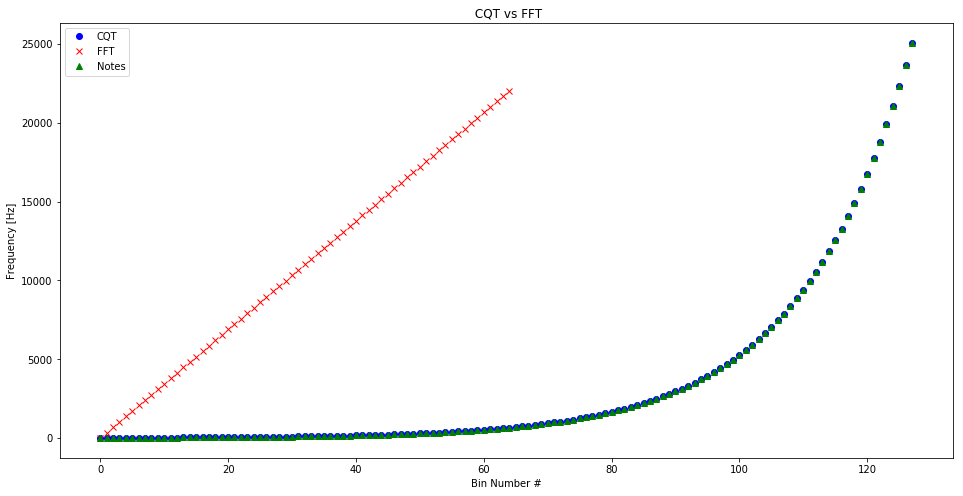

In [8]:
# Plot CQT vs FFT
plt.figure()
plt.plot(cqt_freqs, 'bo', label='CQT')
plt.plot(fft_freqs, 'rx', label= 'FFT')
plt.plot(notes_freqs, 'g^', label = 'Notes')
plt.title(" CQT vs FFT")
plt.xlabel('Bin Number #')
plt.ylabel('Frequency [Hz]')
plt.legend();

In [9]:
# CQT
## Function
def calc_cqt(x,fs=fs,hop_length=hop_length, n_bins=n_bins, mag_exp=mag_exp):
    C = librosa.cqt(x, sr=fs, hop_length=hop_length, fmin=None, n_bins=n_bins)
    C_mag = librosa.magphase(C)[0]**mag_exp
    CdB = librosa.core.amplitude_to_db(C_mag ,ref=np.max)
    return CdB

In [10]:
# CQT Threshold
def cqt_thresholded(cqt,thres=cqt_threshold):
    new_cqt=np.copy(cqt)
    new_cqt[new_cqt<thres]=-120
    return new_cqt

In [11]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/TXPQrJq0ak0?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [12]:
# Onset Envelope from Cqt
def calc_onset_env(cqt):
    return librosa.onset.onset_strength(S=cqt, sr=fs, aggregate=np.mean, hop_length=hop_length)

In [13]:
# Onset from Onset Envelope
def calc_onset(cqt, pre_post_max=pre_post_max, backtrack=True):
    onset_env=calc_onset_env(cqt)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env,
                                           sr=fs, units='frames', 
                                           hop_length=hop_length, 
                                           backtrack=backtrack,
                                           pre_max=pre_post_max,
                                           post_max=pre_post_max)
    onset_boundaries = np.concatenate([[0], onset_frames, [cqt.shape[1]]])
    onset_times = librosa.frames_to_time(onset_boundaries, sr=fs, hop_length=hop_length)
    return [onset_times, onset_boundaries, onset_env]

In [14]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/TTBNIryC8Tw?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [15]:
# Fine Tuning UI
style = {'description_width': 'initial'}
mag_exp_slider=IntSlider(value=mag_exp, min=1, max=32, step=1, 
                         description='mag_exp:',continuous_update=False)

thres_slider=IntSlider(value=cqt_threshold, min=-120, max=0, step=1, 
                                                     description='Threshold:',continuous_update=False)

pre_post_slider=IntSlider(value=pre_post_max, min=1, max=32, step=1, 
                         description='Pre_post_max:',continuous_update=False, style=style)

backtrack_box=Checkbox(value=False,description='backtrack',disabled=False)


def inter_cqt_tuning(mag_exp,thres,pre_post_max, backtrack):
    thres=thres_slider.value
    mag_exp=mag_exp_slider.value
    pre_post_max=pre_post_slider.value
    backtrack=backtrack_box.value
    global CdB
    CdB = calc_cqt(x,fs,hop_length, n_bins, mag_exp)
    plt.figure()
    new_cqt=cqt_thresholded(CdB,thres)
    librosa.display.specshow(new_cqt, sr=fs, hop_length=hop_length, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    plt.ylim([librosa.note_to_hz('B2'),librosa.note_to_hz('B6')])
    global onsets
    onsets=calc_onset(new_cqt,pre_post_max, backtrack)
    plt.vlines(onsets[0], 0, fs/2, color='k', alpha=0.8)
    plt.title("CQT - Sweet Child O' Mine Intro")
    plt.colorbar()
    plt.show()
    
    

In [16]:
# Display UI
out = interactive_output(inter_cqt_tuning,  {'mag_exp': mag_exp_slider, 'thres': thres_slider, 
                                             'pre_post_max': pre_post_slider, 'backtrack':backtrack_box})
ui = VBox([mag_exp_slider, thres_slider, pre_post_slider, backtrack_box])
display(ui, out)

Output()

In [17]:
# Estimate Tempo
tempo, beats=librosa.beat.beat_track(y=None, sr=fs, onset_envelope=onsets[2], hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2))
mm = MetronomeMark(referent='quarter', number=tempo)

In [18]:
# Convert Seconds to Quarter-Notes
def time_to_beat(duration, tempo):
    return (tempo*duration/60)

In [19]:
# Remap input to 0-1 for Sine Amplitude or to 0-127 for MIDI
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [20]:
# Generate Sinewave, MIDI Notes and music21 notes
def generate_sine_midi_note(f0_info, sr, n_duration, round_to_sixtenth=True):
    f0=f0_info[0]
    A=remap(f0_info[1], CdB.min(), CdB.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=fs, hop_length=hop_length)
    #Generate Midi Note and music21 note
    note_duration = 0.02*np.around(duration/2/0.02) # Round to 2 decimal places for music21 compatibility
    midi_duration = time_to_beat(duration, tempo)
    midi_velocity=int(round(remap(f0_info[1], CdB.min(), CdB.max(), 0, 127)))
    if round_to_sixtenth:
        midi_duration=round(midi_duration*16)/16
    if f0==None:
        midi_note=None
        note_info=Rest(type=mm.secondsToDuration(note_duration).type)
        f0=0
    else:
        midi_note=round(librosa.hz_to_midi(f0))
        note = Note(librosa.midi_to_note(midi_note), type=mm.secondsToDuration(note_duration).type)
        note.volume.velocity = midi_velocity
        note_info = [note]
    midi_info = [midi_note, midi_duration, midi_velocity]
            
    # Generate Sinewave
    n = np.arange(librosa.frames_to_samples(n_duration, hop_length=hop_length ))
    sine_wave = A*np.sin(2*np.pi*f0*n/float(sr))
    return [sine_wave, midi_info, note_info]

In [21]:
#Estimate Pitch
def estimate_pitch(segment, threshold):
    freqs = librosa.cqt_frequencies(n_bins=n_bins, fmin=librosa.note_to_hz('C1'),
                            bins_per_octave=12)
    if segment.max()<threshold:
        return [None, np.mean((np.amax(segment,axis=0)))]
    else:
        f0 = int(np.mean((np.argmax(segment,axis=0))))
    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]

In [22]:
# Generate notes from Pitch estimation
def estimate_pitch_and_notes(x, onset_boundaries, i, sr):
    n0 = onset_boundaries[i]
    n1 = onset_boundaries[i+1]
    f0_info = estimate_pitch(np.mean(x[:,n0:n1],axis=1),threshold=cqt_threshold)
    return generate_sine_midi_note(f0_info, sr, n1-n0)

In [23]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/KyvxLFMIo7E?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [24]:
# Array of music information - Sinewave, MIDI Notes and muisc21 Notes
music_info = np.array([
    estimate_pitch_and_notes(CdB, onsets[1], i, sr=fs)
    for i in range(len(onsets[1])-1)
])

In [25]:
# Get sinewave 
synth_audio=np.concatenate(music_info[:,0])

In [26]:
# Play generatade sinewave
ipd.Audio(synth_audio, rate=fs)

In [27]:
# Get muisc21 notes
note_info = list(music_info[:,2])

In [28]:
# Create music21 stream
s = Stream()
s.append(mm)
electricguitar = instrument.fromString('electric guitar')
electricguitar.midiChannel=0
electricguitar.midiProgram=30  #Set program to Overdriven Guitar
s.append(electricguitar)
s.insert(0, metadata.Metadata())
s.metadata.title = "Sweet Child O' Mine - Introduction"
s.metadata.composer = "Guns n' Roses"
for note in note_info:
    s.append(note)

In [29]:
# Analyse music21 stream to get song Key
key=s.analyze('key')
print(key.name)
# Insert Key to Stream
s.insert(0, key)

C# major


In [30]:
# Display music21 stream
# If you have Musescore installed and configured displays music score - https://musescore.org/en
#s.show() # You must have Nusescore installed and Configured to run this and display the music score

# Show stream as text
s.show('text')

{0.0} <music21.metadata.Metadata object at 0x7f27620435c0>
{0.0} <music21.instrument.ElectricGuitar Electric Guitar>
{0.0} <music21.tempo.MetronomeMark allegro moderato Quarter=130>
{0.0} <music21.key.Key of C# major>
{0.0} <music21.note.Rest rest>
{1.0} <music21.note.Note C#>
{1.5} <music21.note.Note C#>
{1.75} <music21.note.Note G#>
{2.25} <music21.note.Note F#>
{2.75} <music21.note.Note F#>
{3.0} <music21.note.Note G#>
{3.5} <music21.note.Note F>
{4.0} <music21.note.Note G#>
{4.5} <music21.note.Note C#>
{5.0} <music21.note.Note C#>
{5.5} <music21.note.Note G#>
{6.0} <music21.note.Note F#>
{6.5} <music21.note.Note F#>
{7.0} <music21.note.Note G#>
{7.5} <music21.note.Note F>
{8.0} <music21.note.Note G#>
{8.25} <music21.note.Note D#>
{8.75} <music21.note.Note C#>
{9.0} <music21.note.Note G#>
{9.5} <music21.note.Note F#>
{10.0} <music21.note.Note F#>
{10.5} <music21.note.Note G#>
{11.0} <music21.note.Note F>
{11.5} <music21.note.Note G#>
{12.0} <music21.note.Note D#>
{12.5} <music21.not

In [31]:
# Listen to music21 stream as MIDI
s.show('midi') 

# Pygame play - Needs pygame to be installed
#sp = midi.realtime.StreamPlayer(s)
#sp.play()

In [32]:
# Save MIdi to file
s.write('midi', 'sweet_child_music21.mid')

# Another way for saving midi
#mf = midi.translate.streamToMidiFile(s)
#mf.open('sweet_child_mine'+'.mid', 'wb')
#mf.write()
#mf.close()


'sweet_child_music21.mid'

In [33]:
# If you have MuseScore installed, opens midi file in it
#! "D:\ProgramFiles\MuseScore2\bin\MuseScore.exe" sweet_child_music21.mid

In [34]:
# Get MIDI Information
midi_info = list(music_info[:,1])

In [35]:
# Save midi file from MIDI information using MIDIUtils - not using anything from music21, 
track    = 0
channel  = 0
tempo    = tempo  # In BPM
volume   = 100  # 0-127, as per the MIDI standard

gnr = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                      # automatically)
gnr.addTrackName(0,0,"Guns n' Roses - Sweet Child O' Mine - Intro")
program = 30 # Overdriven Guitar
gnr.addProgramChange(track, channel, 0, program)
gnr.addTempo(track, 0, tempo)

note_time=0
for i, note in enumerate(midi_info):
    if note[0]==None:
        note_time+=note[1]
    else:
        note_time+=note[1]
        gnr.addNote(track, channel, note[0].astype('int'), note_time, note[1], note[2])

with open("sweet_child_midiutils.mid", "wb") as output_file:
    gnr.writeFile(output_file)

In [36]:
#! "D:\ProgramFiles\MuseScore2\bin\MuseScore.exe" sweet_child_midiutils.mid